In [154]:
from Crawling_Dataset import Crawling_Nomal_Dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import cv2 
import os
import numpy as np
from torchvision import transforms
import torch.utils.data as data
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
import math
import tqdm as tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [79]:
test_path = '/opt/ml/data/celeb_30/cut_test'
train_path = '/opt/ml/data/celeb_30/cut_train'
BATCH_SIZE = 200

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [4]:
transform = transforms.Compose([
        np.float32,
        transforms.ToTensor(),  # range [0, 255] -> [0.0, 1.0]
        fixed_image_standardization
    ])

In [80]:
test_dataset = Crawling_Nomal_Dataset(test_path, transforms=transform)
train_dataset = Crawling_Nomal_Dataset(train_path, transforms=transform)
test_embedding_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)
train_embedding_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)

In [81]:
labels = train_dataset.name_labels

In [82]:
NUM2NAME_dict = train_dataset.get_label_dict_NUM2NAME()
NAME2NUM_dict = train_dataset.get_label_dict_NAME2NUM()
print(NUM2NAME_dict)

{0: 'Jokyuhyun', 1: 'Leeseungki', 2: 'Parknarae', 3: 'Leegookju', 4: 'Parkhaseon', 5: 'BTSsuga', 6: 'Parkjiseong', 7: 'Jojeongseok', 8: 'Jangdoyoun', 9: 'Taeyeon', 10: 'Ohyeonseo', 11: 'Chunwoohee', 12: 'Shinsekyung', 13: 'Ahnyoungmi', 14: 'Hanhyojoo', 15: 'Sonhuengmin', 16: 'BTSjhin', 17: 'Yimsiwan', 18: 'SongJoongki', 19: 'Yooyeonseok'}


In [83]:
model = InceptionResnetV1(
    classify=False,
    pretrained='vggface2'
).to(device)

In [84]:
def get_embedding(feature ) :
    feature = feature.to(device)
    embedding = model(feature)
    embedding = embedding.to('cpu').numpy()
    return embedding

In [85]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric

    return dist

In [86]:
def calculate(rank_list, train_label) :
    count = 0
    for dis, label in rank_list :
        if label == train_label :
            count += 1
    return count

In [125]:
def get_embedding_from_file(FILEPATH) :
    model.eval()
    with torch.no_grad() :
        test_dataset = Crawling_Nomal_Dataset(test_path, transforms=transform)
        test_embedding_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=2, drop_last=False)
        
        for feature, path_label_list in test_embedding_loader :
            embeddings = get_embedding(feature)
            print(len(path_label_list[1]))
            print(path_label_list[1])
            print(embeddings.shape)
            return embeddings, path_label_list

In [126]:
test_embeddings, path_label_list = get_embedding_from_file(test_path)

200
tensor([18, 17,  9,  0, 15,  0,  8, 13,  1,  3,  8, 10,  0, 14, 16,  8,  2, 11,
         1,  0,  9,  4,  2,  5, 11,  6,  3, 13, 17,  6,  4, 16,  1, 14,  4,  3,
         5, 17, 10, 19,  7, 17,  8,  0,  2, 18,  5, 14,  8, 12,  9,  3,  5, 13,
        11,  7, 10,  7, 15, 13, 12, 10,  9, 15, 13,  9,  3, 19, 12, 16, 13, 18,
        12,  9, 16,  4,  9,  1, 15, 18, 12, 10, 11,  6,  6, 12,  5,  1,  1, 17,
         5, 14,  5, 12,  8,  0, 18, 17, 19,  8,  2, 11, 17, 13,  5,  2,  4,  9,
         9, 10,  6,  9, 15, 18, 10, 12,  2, 16, 11,  8, 16,  3, 14,  6, 17, 19,
         7,  4, 15, 16,  7, 17,  3,  4,  4, 15, 15,  0,  5,  6, 16, 12,  7, 18,
         2, 19, 14,  6,  7, 19,  3, 14,  1, 15,  1, 14, 19, 14,  0, 16,  3, 10,
        15, 18,  0,  8,  4, 11,  2,  0,  7, 16, 19, 11,  8, 17, 12, 11,  1, 11,
        13, 13,  4, 19, 18,  7,  5,  2,  6, 18,  7,  3, 10,  2,  1, 14, 13, 10,
        19,  6])
(200, 512)


In [158]:
TOP_NUM = 10
eu_ten_check_list = []
correct_count_dict = defaultdict(lambda : 0)
model.eval()
with torch.no_grad():
    for idx,(feature, b) in enumerate(tqdm.tqdm(train_embedding_loader, leave=True)) :
        train_embedding = get_embedding(feature)
        train_label = b[1].tolist()[0]
        train_image_path = b[0][0]
        eu_label_embedding_list = []

        eu_dist = distance(train_embedding, test_embeddings)
        # print(eu_dist.shape)
        test_label_list = path_label_list[1].tolist()
        # print(test_label_list)
        for pair in zip(eu_dist, test_label_list) :
            eu_label_embedding_list.append(pair)
            
        # for test_feature, label_list in test_embedding_loader :
        #     test_embedding = get_embedding(test_feature)
        #     label_num_list = label_list[1].tolist()
            
        #     eu_dist = distance(train_embedding, test_embedding, 0)
            
        #     for pair in zip(eu_dist, label_num_list) :
        #         eu_label_embedding_list.append(pair)

        eu_label_embedding_list = sorted(eu_label_embedding_list)
        eu_top_rank_list = eu_label_embedding_list[:TOP_NUM]
        if train_label == 16 :   # 이건 확인용 급조해서 만든거 없애도댐
            print(eu_top_rank_list)
        # print(eu_top_rank_list)
        count = calculate(eu_top_rank_list, train_label)
        correct_count_dict[train_label] += count
        if count < 7 :
            eu_ten_check_list.append((train_image_path,train_label))
        


  8%|▊         | 16/200 [00:00<00:09, 18.59it/s]

[(0.22715609, 18), (0.22741407, 18), (0.28151724, 18), (0.35336414, 18), (0.37183517, 18), (0.3722916, 18), (0.3915251, 17), (0.4009793, 0), (0.40530944, 5), (0.4460669, 18)]


 23%|██▎       | 46/200 [00:01<00:04, 37.22it/s]

[(0.21086983, 18), (0.29048774, 18), (0.3078477, 5), (0.31499746, 18), (0.31937107, 5), (0.32024938, 18), (0.32824045, 18), (0.33824158, 5), (0.34618402, 17), (0.3495636, 18)]
[(0.24648365, 18), (0.2555081, 18), (0.26898947, 18), (0.31300282, 18), (0.37705398, 18), (0.3905317, 18), (0.41852236, 18), (0.43615037, 5), (0.43673223, 5), (0.4549584, 18)]


 30%|███       | 61/200 [00:01<00:03, 40.79it/s]

[(0.2573493, 18), (0.3298228, 18), (0.34712887, 18), (0.34826508, 18), (0.40126008, 18), (0.4239573, 18), (0.4923014, 18), (0.545726, 18), (0.54696715, 0), (0.55240214, 18)]
[(0.12408601, 18), (0.20415822, 18), (0.27541518, 18), (0.2846707, 18), (0.32116258, 18), (0.36007893, 18), (0.370663, 19), (0.37831637, 18), (0.39323568, 18), (0.40301722, 5)]


 53%|█████▎    | 106/200 [00:02<00:02, 42.78it/s]

[(0.17772144, 18), (0.24194115, 18), (0.25650725, 18), (0.2774752, 18), (0.28386086, 18), (0.30267584, 18), (0.3691311, 17), (0.39899504, 16), (0.40363747, 18), (0.4124686, 5)]
[(0.24434718, 18), (0.2854603, 17), (0.341173, 18), (0.3435825, 18), (0.35566637, 18), (0.36694592, 17), (0.37812978, 18), (0.39499986, 17), (0.4114213, 17), (0.4237615, 18)]


 70%|███████   | 141/200 [00:03<00:01, 43.10it/s]

[(0.12685397, 18), (0.16899484, 18), (0.1957633, 18), (0.238893, 18), (0.2869403, 18), (0.32035208, 18), (0.36144686, 18), (0.39064765, 17), (0.4069754, 18), (0.42529437, 18)]


 83%|████████▎ | 166/200 [00:03<00:00, 42.96it/s]

[(0.13478875, 18), (0.19191918, 18), (0.21631525, 18), (0.28454667, 18), (0.28840366, 5), (0.3170032, 18), (0.36756092, 18), (0.37397134, 16), (0.37579444, 18), (0.3833344, 18)]


100%|██████████| 200/200 [00:04<00:00, 41.80it/s]

[(0.31273338, 18), (0.36055803, 0), (0.36323112, 5), (0.37601766, 18), (0.37884468, 17), (0.40645564, 5), (0.4098518, 5), (0.41443175, 18), (0.41945404, 17), (0.42133802, 18)]


In [135]:
print(correct_count_dict)

defaultdict(<function <lambda> at 0x7f2bb1b35ee0>, {'Ahnyoungmi': 33, 'Leegookju': 95, 'Yimsiwan': 68, 'Ohyeonseo': 69, 'Jokyuhyun': 53, 'Taeyeon': 53, 'Yooyeonseok': 92, 'Sonhuengmin': 63, 'Parknarae': 78, 'SongJoongki': 1, 'Parkjiseong': 95, 'Chunwoohee': 75, 'Jojeongseok': 89, 'Parkhaseon': 58, 'Jangdoyoun': 52, 'Hanhyojoo': 62, 'Leeseungki': 81, 'Shinsekyung': 72, 'BTSsuga': 75, 'BTSjhin': 2})


<BarContainer object of 20 artists>

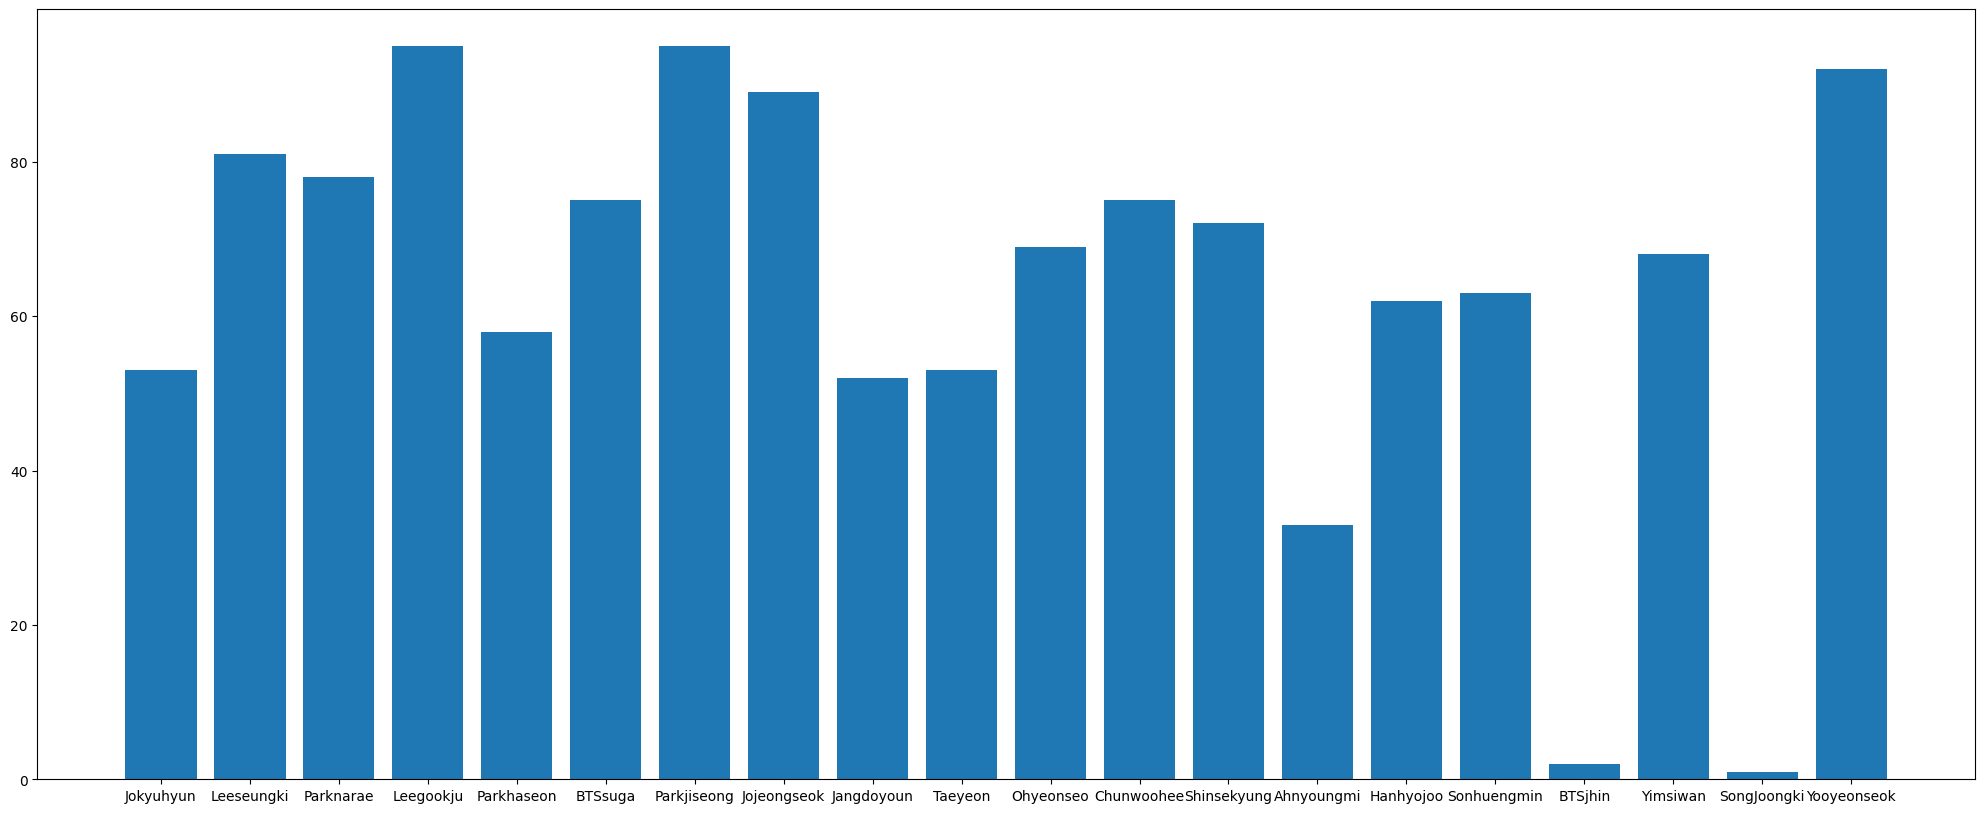

In [151]:
item = correct_count_dict.items()
item = sorted(item)
name = []
counts = []
for label, count in item :
    name.append(NUM2NAME_dict[label])
    counts.append(count)
plt.figure(figsize=(25,10))
plt.bar(name, counts)

In [144]:
(correct_fif_count_dict)

defaultdict(<function __main__.<lambda>()>, {})

<BarContainer object of 20 artists>

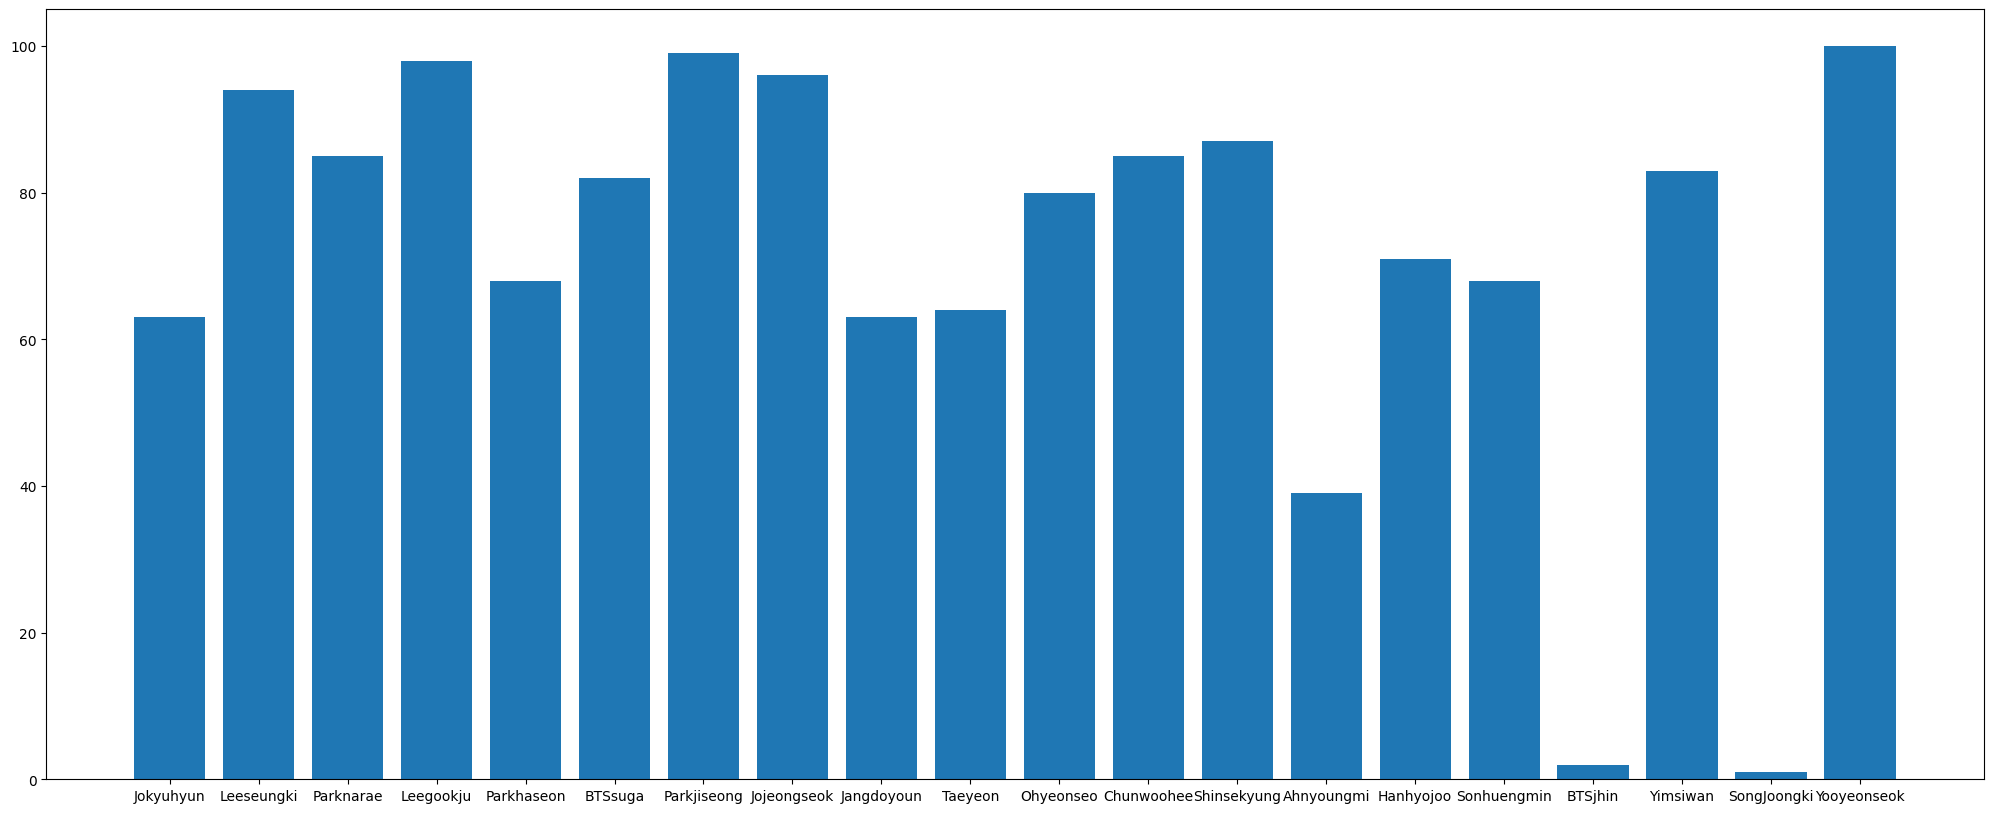

In [149]:
item = correct_fif_count_dict.items()
item = sorted(item)
name = []
counts = []
for label, count in item :
    name.append(NUM2NAME_dict[label])
    counts.append(count)
plt.figure(figsize=(25,10))
plt.bar(name, counts)

In [53]:
print(len(eu_check_list))

56


defaultdict(<function <lambda> at 0x7f2c55084700>, {17: 1, 14: 3, 16: 10, 9: 4, 18: 10, 13: 8, 5: 1, 15: 2, 12: 1, 4: 3, 8: 5, 0: 6, 11: 1, 2: 1})


<function matplotlib.pyplot.show(close=None, block=None)>

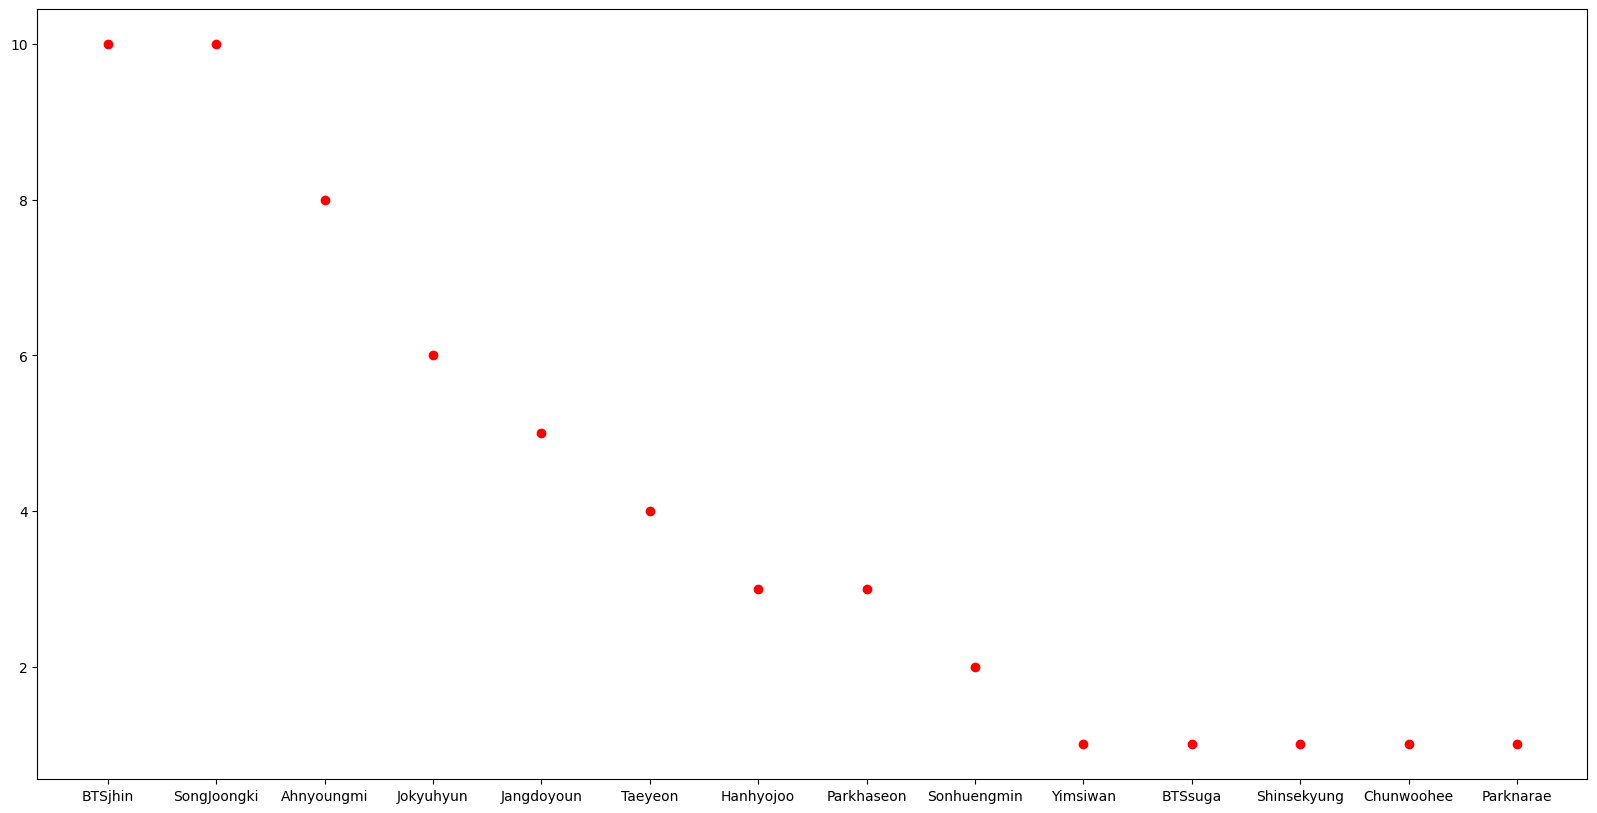

In [137]:
from collections import defaultdict

d = defaultdict(lambda : 0)
for path, label in eu_check_list :
    d[label] += 1
    
print(d)
a = d.items()
a = sorted(a, key = lambda x: x[1], reverse = True)
label_list = []
count_list = []
for label, count in a :
    name = NUM2NAME_dict[label]
    label_list.append(name)
    count_list.append(count)
plt.figure(figsize=(20,10))
plt.plot(label_list, count_list, 'or')
plt.show

NameError: name 'num_class_imges' is not defined

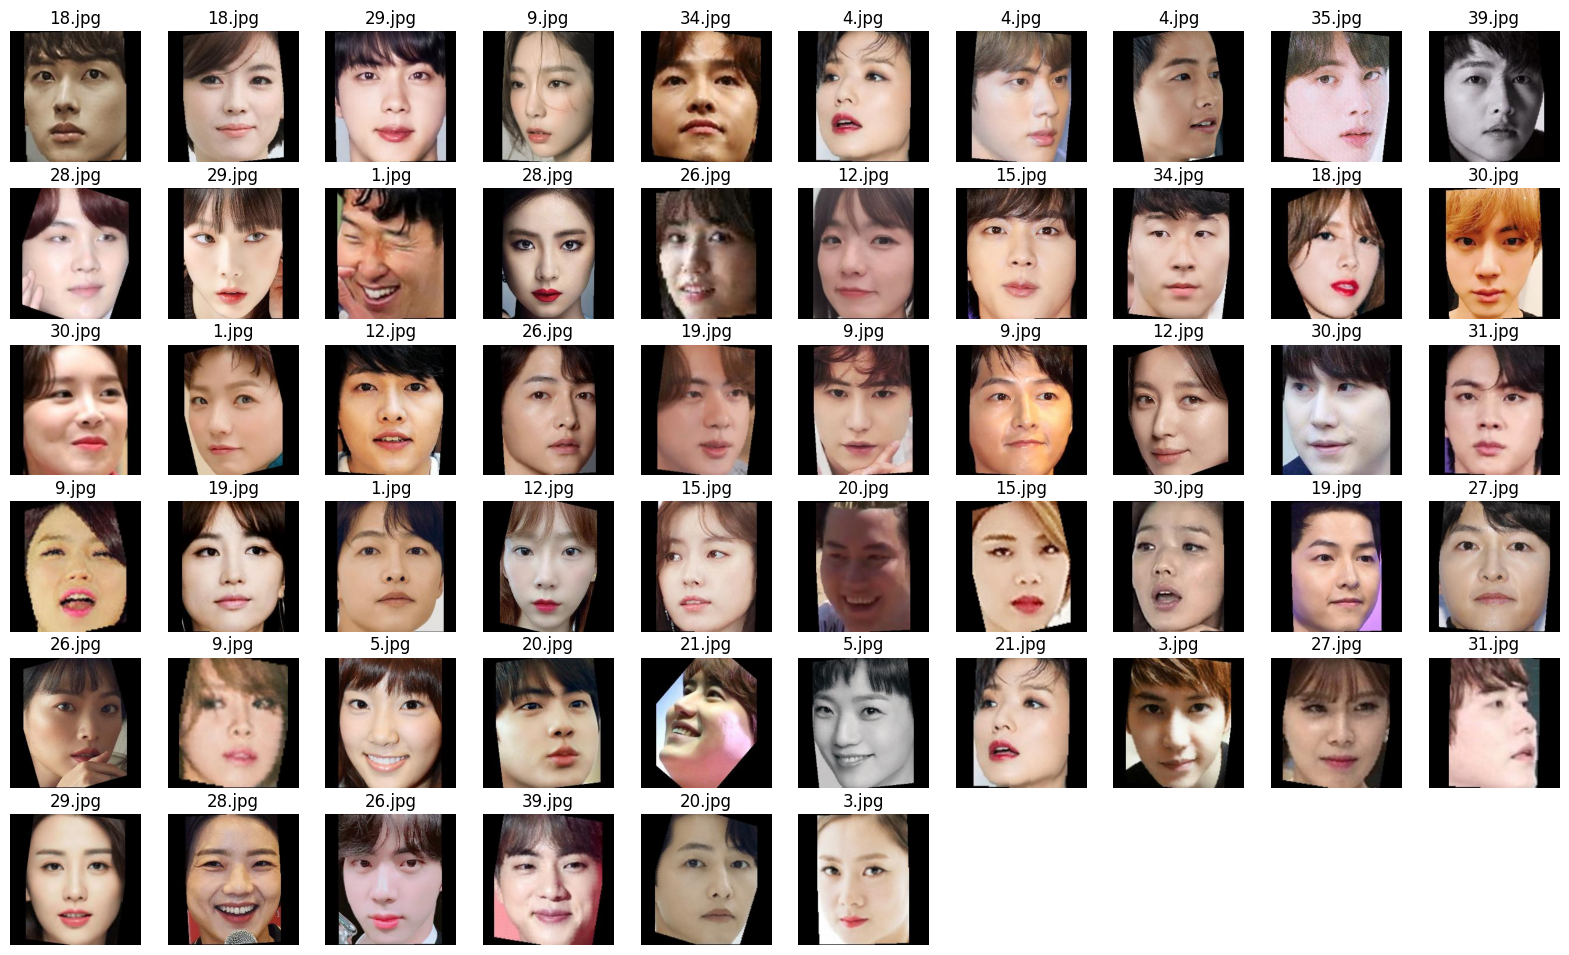

In [58]:
fig = plt.figure(figsize=(20,20))
for i, fullpath in enumerate(eu_check_list):
    fullpath = fullpath[0]
    # print(fullpath[0])
    labels_list = fullpath.split('_')
    label_num = labels_list[-1]
    img_label = labels_list[-2]
    img=Image.open(fullpath)
    # print(type(img))
    globals()[f'ax{i+1}'] = fig.add_subplot(10,10,i+1)
    globals()[f'ax{i+1}'].imshow(img)
    globals()[f'ax{i+1}'].set_title(f'{label_num}')
    globals()[f'ax{i+1}'].axis('off')
# print(len(num_class_imges))

In [124]:
print(len(eu_ten_check_list))

81


In [78]:
print(NUM2NAME_dict)

{0: 'Jokyuhyun', 1: 'Leeseungki', 2: 'Parknarae', 3: 'Leegookju', 4: 'Parkhaseon', 5: 'BTSsuga', 6: 'Parkjiseong', 7: 'Jojeongseok', 8: 'Jangdoyoun', 9: 'Taeyeon', 10: 'Ohyeonseo', 11: 'Chunwoohee', 12: 'Shinsekyung', 13: 'Ahnyoungmi', 14: 'Hanhyojoo', 15: 'Sonhuengmin', 16: 'BTSjhin', 17: 'Yimsiwan', 18: 'SongJoongki', 19: 'Yooyeonseok'}


In [77]:
from collections import defaultdict

d = defaultdict(lambda : 0)
for path, label in eu_ten_check_list :
    d[label] += 1
    
print(d)
a = d.items()
a = sorted(a, key = lambda x: x[1], reverse = True)
print(a)
print(len(a))

defaultdict(<function <lambda> at 0x7f2bb13bf8b0>, {16: 10, 0: 7, 12: 3, 13: 9, 15: 4, 18: 10, 8: 7, 4: 6, 14: 3, 11: 3, 9: 8, 7: 1, 2: 1, 10: 2, 17: 4, 5: 2, 1: 1})
[(16, 10), (18, 10), (13, 9), (9, 8), (0, 7), (8, 7), (4, 6), (15, 4), (17, 4), (12, 3), (14, 3), (11, 3), (10, 2), (5, 2), (7, 1), (2, 1), (1, 1)]
17


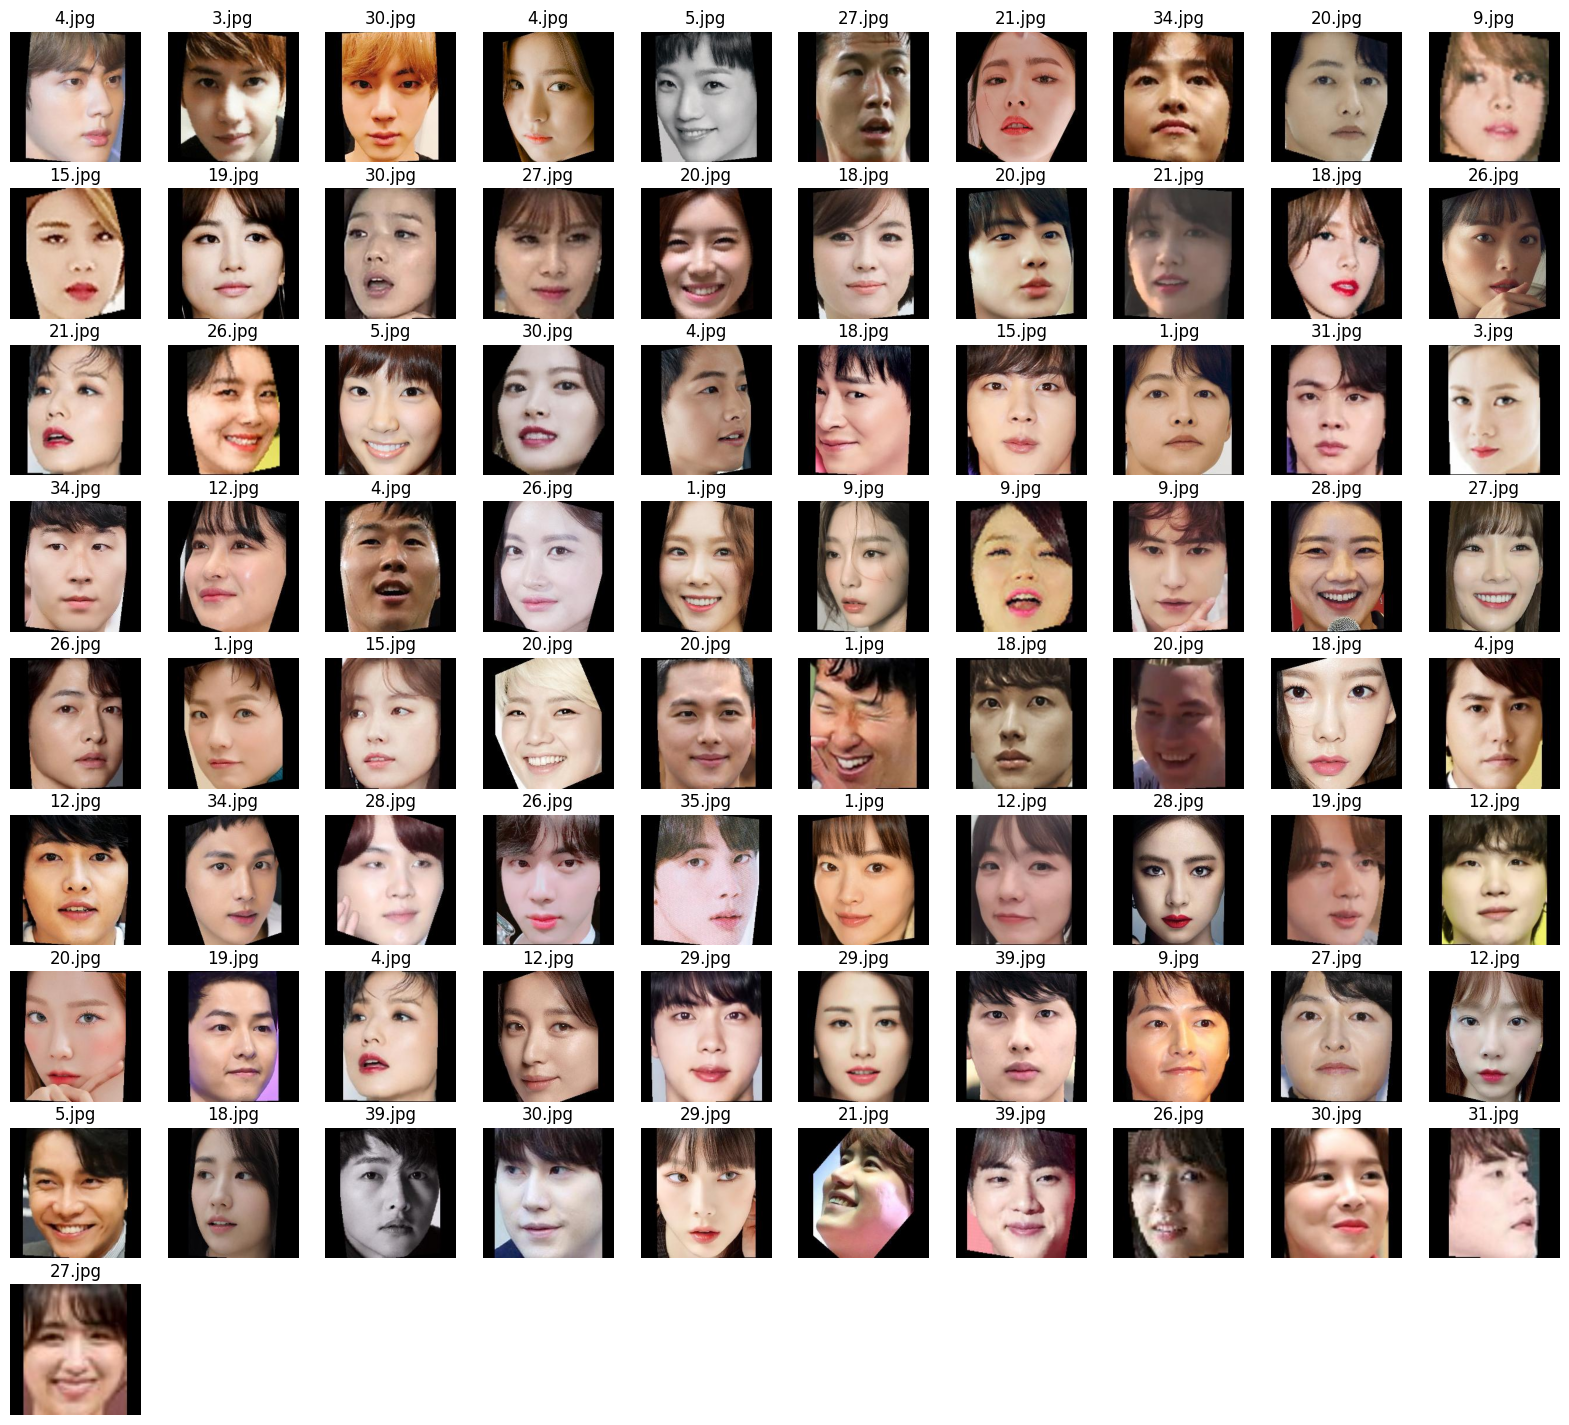

In [76]:
fig = plt.figure(figsize=(20,20))
for i, fullpath in enumerate(eu_ten_check_list):
    fullpath = fullpath[0]
    labels_list = fullpath.split('_')
    label_num = labels_list[-1]
    img_label = labels_list[-2]
    img=Image.open(fullpath)
    globals()[f'ax{i+1}'] = fig.add_subplot(10,10,i+1)
    globals()[f'ax{i+1}'].imshow(img)
    globals()[f'ax{i+1}'].set_title(f'{label_num}')
    globals()[f'ax{i+1}'].axis('off')